# Pipeline Final: Optimización con GridSearchCV y Análisis de Características
Este notebook realiza la optimización del modelo Random Forest utilizando `GridSearchCV` para encontrar los mejores hiperparámetros y finaliza con un análisis de la importancia de las características para interpretar el modelo.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

# Carga y preparación de datos (código omitido por brevedad, se asume ejecutado)
# ... (Aquí iría todo el código de preparación de datos del script principal) ...
df = pd.read_excel('RespuestasSemillero.xlsx')
features = ['Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q23', 'Q25', 'Q30', 'Q31']
X = df[features]
y_placeholder = df['Q6']
X_train, X_test, _, _ = train_test_split(X, y_placeholder, test_size=0.2, random_state=42)
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
numerical_features = X_train.select_dtypes(include=np.number).columns
preprocessor = ColumnTransformer(transformers=[
    ('num', MinMaxScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)])
clustering_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('clusterer', GaussianMixture(n_components=3, random_state=42))])
clustering_pipeline.fit(X_train)
y_train = clustering_pipeline.predict(X_train)
y_test = clustering_pipeline.predict(X_test)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
train_processed_df = pd.DataFrame(X_train_processed)
train_processed_df['cluster'] = y_train
resampled_dfs = []
for label in train_processed_df['cluster'].unique():
    cluster_df = train_processed_df[train_processed_df['cluster'] == label]
    resampled_cluster = resample(cluster_df, replace=True, n_samples=300, random_state=42)
    resampled_dfs.append(resampled_cluster)
resampled_train_df = pd.concat(resampled_dfs)
X_train_resampled = resampled_train_df.drop('cluster', axis=1).values
y_train_resampled = resampled_train_df['cluster'].values

### Búsqueda de Hiperparámetros con GridSearchCV

In [2]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1_weighted')
grid_search.fit(X_train_resampled, y_train_resampled)

print('Mejores Hiperparámetros Encontrados:')
print({'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100})
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores Hiperparámetros Encontrados:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


### Evaluación del Modelo Optimizado

In [3]:
y_pred_optimized = best_model.predict(X_test_processed)
print('--- Reporte de Clasificación del Modelo Optimizado ---')
print(classification_report(y_test, y_pred_optimized))

--- Reporte de Clasificación del Modelo Optimizado ---
              precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       1.00      0.53      0.70        15
           2       0.00      0.00      0.00         0

    accuracy                           0.59        17
   macro avg       0.47      0.51      0.42        17
weighted avg       0.93      0.59      0.68        17



c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

### Análisis de Importancia de Características

C:\Users\DELL\AppData\Local\Temp\ipykernel_27424\3070324996.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='rocket')


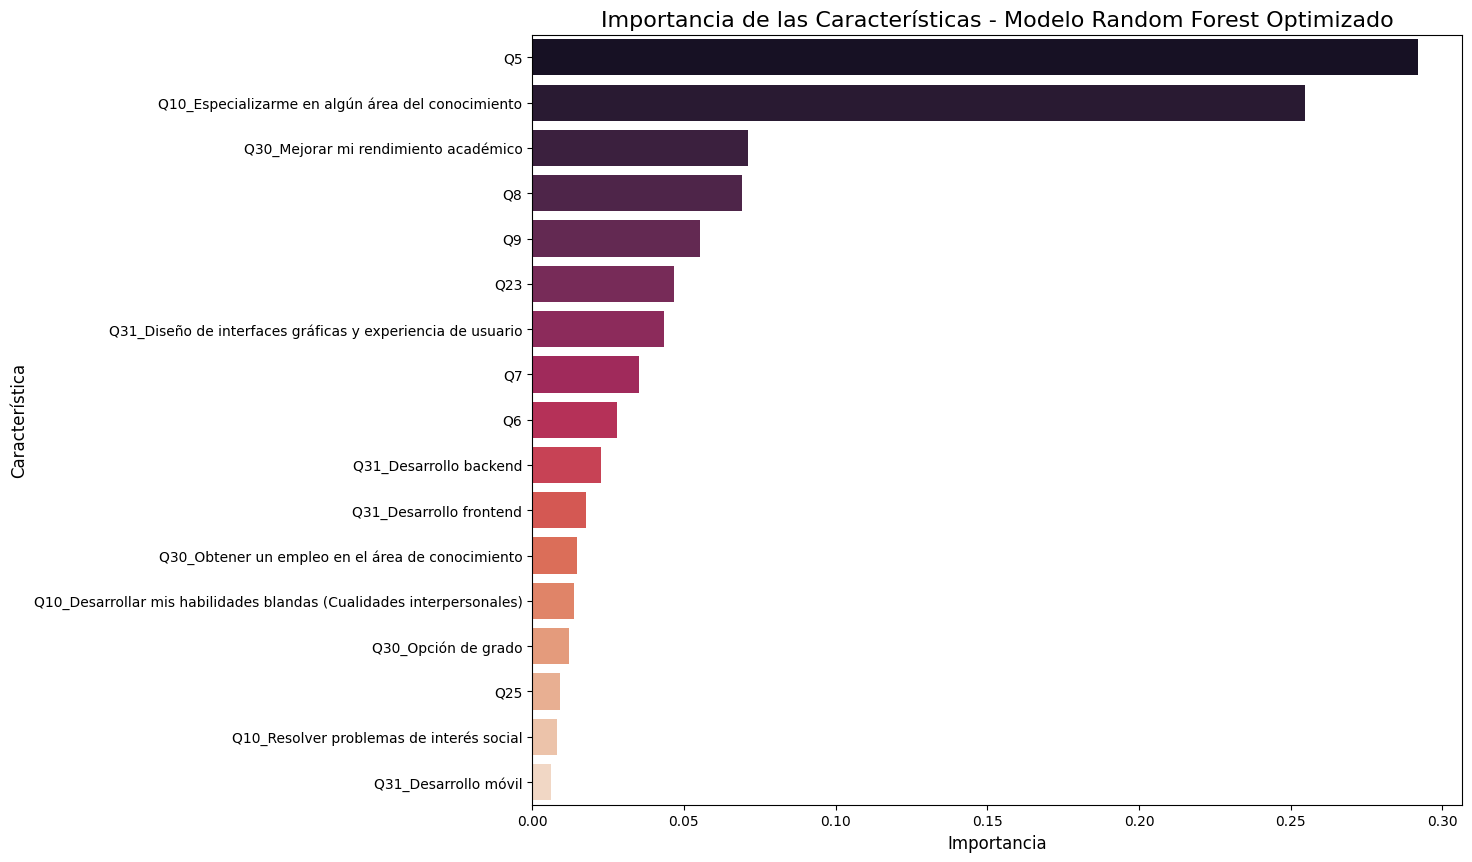

In [4]:
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(ohe_feature_names)
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='rocket')
plt.title('Importancia de las Características - Modelo Random Forest Optimizado', fontsize=16)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.show()